In [1]:
import os
gpu_num = 0 # 使用 "" 来启用 CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility
import matplotlib.pyplot as plt
import numpy as np
import sionna

# Import Sionna RT components
from mysionna.rt import load_scene, Transmitter, Receiver, PlanarArray
from mysionna.rt.scattering_pattern import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
scene = load_scene("Indoor/indoor.xml")
# scene = load_scene(sionna.rt.scene.etoile)

In [3]:
#################配置发端天线阵列#################
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

#################配置收端天线阵列#################
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

In [4]:
################创建发射机#########################
tx = Transmitter(name="tx",
                 position=[0,0,2.95])
tx.look_at([1.9,2.7,1.0])
################ 将发射机加入到场景中##############
scene.add(tx)
#################创建接收机########################
rx = Receiver(name="rx",
              position=[0,0,2.95])
rx.look_at([1.9,2.7,1.0])
################ 将接收机加入到场景中##############
scene.add(rx)


In [5]:
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [6]:
scene.target_names = ["human"]
scene.target_velocities = [(-1.2,-0.4,0.)]

In [7]:
p1 = LambertianPattern()
p2 = DirectivePattern(20)
scene.get("itu_plywood").scattering_coefficient = 0.4
scene.get("itu_plywood").scattering_pattern = p2
scene.get("itu_concrete").scattering_coefficient = 0.3
scene.get("itu_concrete").scattering_pattern = p1
scene.get("itu_floorboard").scattering_coefficient = 0.4
scene.get("itu_floorboard").scattering_pattern = p2
scene.get("itu_ceiling_board").scattering_coefficient = 0.4
scene.get("itu_ceiling_board").scattering_pattern = p2

In [ ]:
crbs = scene.coverage_map_sensing(map_center=[0,0,2.95],
                                  map_size_x=6,
                                  map_size_y=10,
                                  cell_size=0.5,
                                  look_at=[1.9,2.7,1.0],
                                  batch_size=5,
                                  singleBS=True,
                                  num_samples=1000000,
                                  max_depth=3,
                                  diffraction=True,
                                  edge_diffraction=True,
                                  num_time_steps=1)

In [ ]:
crb = None
for i in range(0,len(crbs)):
    c = crbs[i][0]
    c = tf.squeeze(c)
    # c = tf.linalg.diag_part(c)
    c = c.numpy()
    if crb is None:
        crb = c
    else:
        crb = np.concatenate((crb,c),axis=None)
crb = np.array(crb)
np.save("./Data/indoor/crb.npy",crb)
crb = np.reshape(crb,[-1,21])
crb = np.log10(crb)
plt.imshow(crb)
plt.colorbar()

In [8]:
paths = scene.compute_paths(max_depth=3,diffraction=True,scattering=True,edge_diffraction=True)

In [11]:
# scene.preview(paths=paths)

In [9]:
v,obj=scene.compute_target_velocities(paths, return_obj_names=True)

In [10]:
subcarrier_spacing = 15e3
num_time_steps = 1
paths.apply_doppler(sampling_frequency=subcarrier_spacing, num_time_steps=num_time_steps,target_velocities=v)

In [11]:
crb = paths.crb_delay()

In [12]:
paths.export_crb(crb,"test.xyzrgb",BS_pos = [0,0,2.95])

True

/tmp/ipykernel_29248/573708245.py:22: RuntimeWarning: divide by zero encountered in log10
  mse = np.log10(mse)


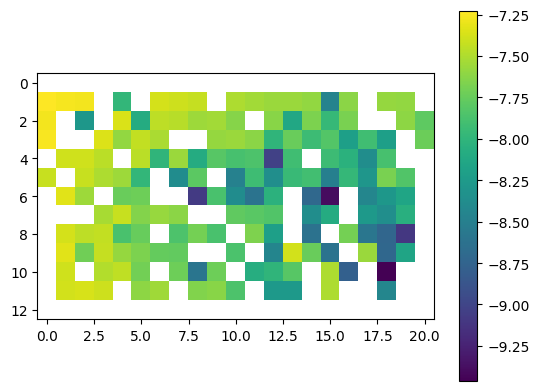

In [12]:
with open("./Data/indoor/tau_true.txt","r") as f:
    tau_true = f.readlines()
    tau_true = np.array([float(i) for i in tau_true])
with open("./Data/indoor/tau_est.txt","r") as f:
    tau_est = f.readlines()
    tau_est = np.array([float(i) for i in tau_est])

mse = np.abs(tau_true - tau_est)
mse = np.reshape(mse,(-1,21))
tau_true = np.reshape(tau_true,(-1,21))
tau_est = np.reshape(tau_est,(-1,21))
mask = mse >= 1
mse[mask] = 0
mask = tau_est==0
mse[mask] = 0
mask = tau_true==999999 
mse[mask] = 0
mask = tau_true==0
mse[mask] = 0
mask = tau_true==-1
mse[mask] = 0
mse = np.log10(mse)
plt.imshow(mse)
plt.colorbar()

In [6]:
np.argmin(mse)

227